In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler

import pyswarms as ps

from tensorflow import keras
from keras import layers, models
from keras import losses

In [2]:
df = pdr.get_data_yahoo('AAPL', start=None, end=None)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data = df.filter(['Close']) # should return a 2D array for the closing prices. Return type is a DataFrame

training_split_length = int(np.ceil(len(data)*.65))

dataset = data.values # Return type of .values is a numpy.ndarray of dim 2

scalar = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scalar.fit_transform(dataset)

scaled_dataset.shape

(10857, 1)

In [4]:
train_data = scaled_dataset[:int(training_split_length),:]

x_train = []
y_train = []

days_in_ahead = 5

for i in range(60,len(train_data)-days_in_ahead):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i+days_in_ahead])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
def create_model(layers, nodes, input_shape=(x_train.shape[1], 1)):
    model = keras.models.Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1
        model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences, input_shape=input_shape))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def evaluate_model(hyperparameters):
    layers, nodes, batch_size, epochs = int(hyperparameters[0]), int(hyperparameters[1]), int(hyperparameters[2]), int(hyperparameters[3])
    model = create_model(layers, nodes)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    val_loss = np.min(history.history['mean_squared_error'])
    return val_loss
    

def objective_function(hyperparameters):
    n_particles = hyperparameters.shape[0]
    j = [evaluate_model(hyperparameters[i]) for i in range(n_particles)]
    return np.array(j)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Define bounds - (min, max) for each hyperparameter
# [Layers, Nodes, Batch Size, Epochs]
lower_bounds = [1, 20, 32, 10]  #Lower bounds for each dimension
upper_bounds = [3, 64, 64, 20]  # Upper bounds for each dimension
bounds = (lower_bounds, upper_bounds)

#Initialize swarm
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds=bounds)

#Perform optimization
cost, pos = optimizer.optimize(objective_function, iters=2)

# Best hyperparameters
print("Best hyperparameters: Layers={}, Nodes={}, Batch Size={}, Epochs={}".format(int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])))

2024-01-06 16:12:45,071 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2/2, best_cost=3.96e-7
2024-01-06 16:31:11,802 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.958791410241247e-07, best pos: [ 1.29713043 45.58460297 37.86215234 19.40443899]


Best hyperparameters: Layers=1, Nodes=45, Batch Size=37, Epochs=19


In [6]:
model = create_model(int(pos[0]), int(pos[1]), (x_train.shape[1], 1))
# model = create_model(1, 60, (x_train.shape[1], 1))

history = model.fit(x=x_train,y=y_train, batch_size=int(pos[2]), epochs=int(pos[3]))

Epoch 1/19
189/189 [==============================] - 4s 11ms/step - loss: 3.4871e-06 - mean_squared_error: 3.4871e-06 - mean_absolute_error: 7.8770e-04
Epoch 2/19
189/189 [==============================] - 2s 12ms/step - loss: 7.3482e-07 - mean_squared_error: 7.3482e-07 - mean_absolute_error: 5.2556e-04
Epoch 3/19
189/189 [==============================] - 2s 11ms/step - loss: 6.6781e-07 - mean_squared_error: 6.6781e-07 - mean_absolute_error: 4.9756e-04
Epoch 4/19
189/189 [==============================] - 2s 10ms/step - loss: 5.8512e-07 - mean_squared_error: 5.8512e-07 - mean_absolute_error: 4.5035e-04
Epoch 5/19
189/189 [==============================] - 2s 10ms/step - loss: 5.8473e-07 - mean_squared_error: 5.8473e-07 - mean_absolute_error: 4.6021e-04
Epoch 6/19
189/189 [==============================] - 2s 10ms/step - loss: 5.5593e-07 - mean_squared_error: 5.5593e-07 - mean_absolute_error: 4.5169e-04
Epoch 7/19
189/189 [==============================] - 2s 10ms/step - loss: 5.7184e

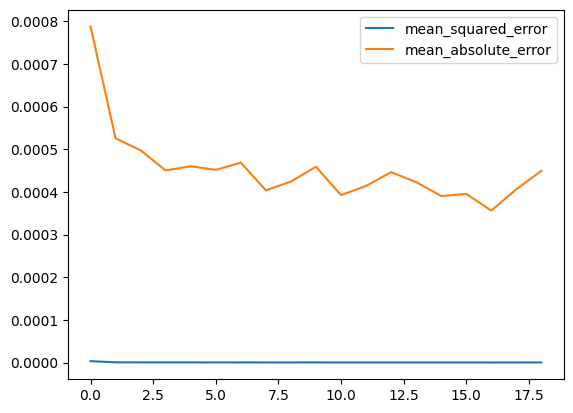

In [7]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['mean_squared_error', 'mean_absolute_error'])
plt.show()

In [8]:
test_data = scaled_dataset[training_split_length-60:,:]
x_test = []
y_test = dataset[training_split_length:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test)**2)))

rmse

119/119 [==============================] - 1s 5ms/step


2.2559418237543976

C:\Users\Brandon\AppData\Local\Temp\ipykernel_25768\227710221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,:]


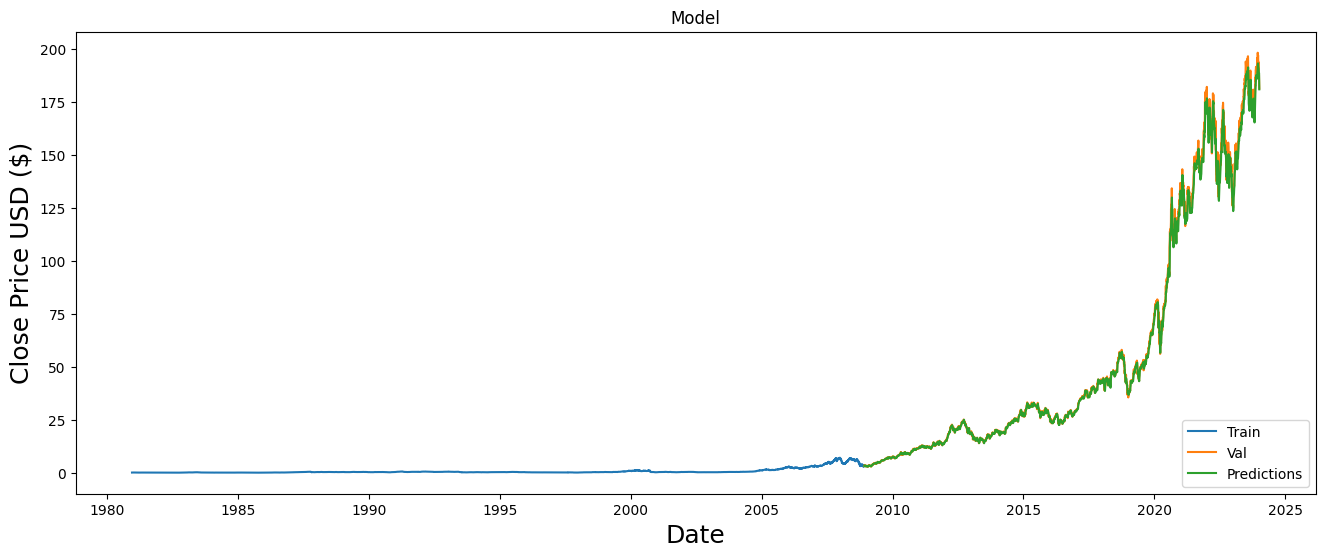

In [9]:
train = data[:training_split_length]
valid = data[training_split_length:]
valid['Predictions'] = predictions[:,:]
#Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [10]:
close_price = valid['Close'].values
prediction_price = valid['Predictions'].values
accuracy = lambda close, pred: min(close, pred)/max(close, pred) * 100
accuracy_lst = np.array([accuracy(close, pred) for close,pred in zip(close_price, prediction_price)])
accuracy = np.average(accuracy_lst)
accuracy

98.055639623528

In [16]:
late_test = scaled_dataset[-60:,:]
late_test = np.reshape(late_test, (1, 60, 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 266ms/step


array([[178.76254]], dtype=float32)